In [ ]:
# might need to run this next line and restart the session for for it to work on Colab
# !pip install matplotlib --upgrade

from google.colab import drive
drive.mount('/content/drive')

# path where the data is contained
path = '/content/drive/MyDrive/IHLT/lab2/'

import pandas as pd
import re
import nltk
from nltk.metrics import jaccard_distance
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np 
from IPython.display import display_html 

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

Authors:
* Benjamí Parellada 
* Clara Rivadulla
# Lab 3

For the third practical of the subject, the goal is to compare the similarity between pairs of sentences, the same as the second practical. The steps are the same, however we test the WordNet Lemmatizer while processing the sentences.

1. Read all pairs of sentences of the SMTeuroparl files.
2. Process the sentences and convert them to tokens. **Apply a Lemmatizer** on the tokens. Use the preprocessing done in the first lab (convert to lowercase, remove stop words, etc.).
3. Compute the similarities between sentences with the Jaccard distance.
4. Compute the Pearson Correlation between the Jaccard Distance and the Golden Standard given to us.
5. Analyze the results.
6. Conclusions.

We begin by importing the necessary packages and initialize the regex, Lemmatizer and creating a set of the stopwords to be able to preprocess the sentences.

In [ ]:
stopw = set(nltk.corpus.stopwords.words('english')) # english stopwords
regex = re.compile('[^a-z0-9]') # regex of alphabetical and 
wnl = WordNetLemmatizer() # initialize the lemmatizer

We create functions to help us lemmatize the tokens. Using wordnet we will lemmatize each token depending on what the POS tag is. We define a dictionary where the different Penn POS will summarized into 4 different types of word (noun, verb, adjective, adverb). After this, we apply it on the sentences.  

In [ ]:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# we need 2 letters since 'RP' exists and is not and adverb
tags = {'NN': wordnet.NOUN,
        'VB': wordnet.VERB,
        'JJ': wordnet.ADJ, 
        'RB': wordnet.ADV}

def pos_wn(pair):
  word = pair[0].lower()
  tag = tags.get(pair[1][:2].upper())
  if tag != None:
     word = wnl.lemmatize(word, pos = tag)
  return word

def lemmatize(tokens):
    pairs = nltk.pos_tag(tokens)
    lemmatized = [pos_wn(pair) for pair in pairs]
    return lemmatized

In [ ]:
def text_preprocessing(sentence):
  tokens = nltk.word_tokenize(sentence) # tokenize
  tokens = lemmatize(tokens) # lemmatize
  tokens = [regex.sub('', w) for w in tokens if not w in stopw] # remove stopwords and symbols from each word
  tokens = [w for w in tokens if w] # remove empty elements
  return set(tokens)

def text_preprocessing_old(sentence):
  tokens = nltk.word_tokenize(sentence)
  tokens = [regex.sub('', w.lower()) for w in tokens if not w.lower() in stopw] # remove stopwords and symbols from each word
  tokens = [w for w in tokens if w] # remove empty elements
  return set(tokens)

In [ ]:
dt = pd.read_csv(path + 'STS.input.SMTeuroparl.txt', sep='\t', header = None)
dt[2] = dt.apply(lambda row: text_preprocessing(row[0]), axis = 1)
dt[3] = dt.apply(lambda row: text_preprocessing(row[1]), axis = 1)
dt['gs'] = pd.read_csv(path + 'STS.gs.SMTeuroparl.txt', sep='\t', header = None)
dt['jac'] = dt.apply(lambda row: 5*(1 - jaccard_distance(row[2], row[3])), axis = 1)
dt.head()

,0,1,2,3,gs,jac
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,"{seize, chance, let, new, hope, give, leader, us}","{aujourd, luck, seize, let, benefit, new, s, l...",4.50,1.428571
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,"{propose, reference, 7, paragraph, certain, ch...","{propose, reference, 7, paragraph, certain, ch...",5.00,5.000000
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,"{ally, include, let, remind, tax, fervent, sup...","{ally, remind, among, would, like, strong, tax}",4.25,1.363636
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,"{vote, pm, take, 530, today, place}","{530pm, place, vote, take}",4.50,2.142857
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...","{inactive, tired, disappointed, fisherman}","{inactive, tired, disappointed, fisherman}",5.00,5.000000


In [ ]:
pearsonr(dt['gs'], dt['jac'])[0]

0.4826914665777867

We still have problems that we detected in the previous session appear here. We know that synonyms are being ignored and thus the worst performing sentences are those that contain many synonyms. Since most of the conclusions are the same as practical 2, we decided to also observe the sentences which we give a higher score than the gold standard.

For sentence 307 and 409 we agree more with our score that they are exactly the same. Sentence 209 can be argued that both the gold standard and our method are wrong and while the sentence appears similar, the meaning is not the same. We also notice row 171 and 108, which are similar to 209, but different.

In [ ]:
dt['diff'] = abs(dt['jac'] - dt['gs'])
dt_worst = dt.sort_values(by=['diff'], ascending=False).head(3)
df1_styler = dt_worst.style.set_table_attributes("style='display:inline'").set_caption('Highest difference between Jaccard and Gold Standard')
display_html(df1_styler._repr_html_(), raw=True)

dt['diff'] = dt['jac'] - dt['gs']
dt_better = dt.sort_values(by=['diff'], ascending=False).head(5)
df1_styler = dt_better.style.set_table_attributes("style='display:inline'").set_caption('Highest positive difference between Jaccard and Gold Standard')
display_html(df1_styler._repr_html_(), raw=True)

# for later
dt['diff'] = abs(dt['jac'] - dt['gs'])

,0,1,2,3,gs,jac,diff
452,Then perhaps we could have avoided a catastrophe.,We might have been able to prevent a disaster.,"{'catastrophe', 'could', 'perhaps', 'avoid'}","{'prevent', 'able', 'disaster', 'might'}",4.250000,0.000000,4.250000
335,"Consumers will lose out, employees will lose out, Europe will lose competitive strength and growth.","Users are the losers, with workers and European competitiveness and innovation régresseront.","{'consumer', 'europe', 'lose', 'employee', 'growth', 'strength', 'competitive'}","{'european', 'innovation', 'rgresseront', 'loser', 'user', 'worker', 'competitiveness'}",4.250000,0.000000,4.250000
236,I am one of those Members who attends sittings quite faithfully.,I form part of the members of Parliament who are rather honourably present.,"{'sitting', 'one', 'member', 'faithfully', 'attend', 'quite'}","{'present', 'rather', 'part', 'parliament', 'honourably', 'form', 'member'}",4.500000,0.416667,4.083333


,0,1,2,3,gs,jac,diff
307,Tunisia,Tunisia was,{'tunisia'},{'tunisia'},3.750000,5.000000,1.250000
409,(Parliament adopted the legislative resolution),(the Parliament adopts the legislative resolution),"{'resolution', 'adopt', 'parliament', 'legislative'}","{'resolution', 'adopt', 'parliament', 'legislative'}",4.000000,5.000000,1.000000
209,There must be a balance as a whole.,The whole must be balanced.,"{'must', 'whole', 'balance'}","{'must', 'whole', 'balance'}",4.250000,5.000000,0.750000
171,There must be a balance as a whole.,The whole must be in balance.,"{'must', 'whole', 'balance'}","{'must', 'whole', 'balance'}",4.667000,5.000000,0.333000
108,There must be a balance as a whole.,The whole must be in balance.,"{'must', 'whole', 'balance'}","{'must', 'whole', 'balance'}",4.667000,5.000000,0.333000


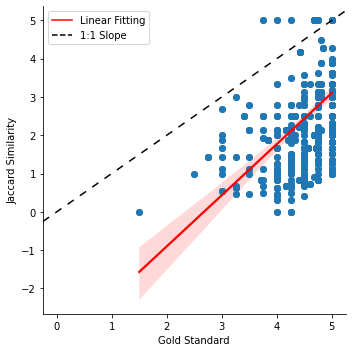

In [ ]:
sns.lmplot(x = 'gs', y = 'jac', data = dt, line_kws = {'color': 'red'});
plt.scatter(dt['gs'], dt['jac'])
plt.xlabel("Gold Standard")
plt.ylabel("Jaccard Similarity")
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
ols = mlines.Line2D([], [], color='red', label='Linear Fitting')
lin = mlines.Line2D([], [], color='black', linestyle='--', label='1:1 Slope')
plt.legend(loc='upper left', handles = [ols, lin] )
plt.show()

In [ ]:
# comparision word vs lemma
dt[6] = dt.apply(lambda row: text_preprocessing_old(row[0]), axis = 1)
dt[7] = dt.apply(lambda row: text_preprocessing_old(row[1]), axis = 1)
dt['jac_word'] = dt.apply(lambda row: 5*(1 - jaccard_distance(row[6], row[7])), axis = 1)
dt['diff_word'] = abs(dt['jac_word'] - dt['gs'])
dt['diff_type'] = abs(dt['jac_word'] - dt['jac'])

# Conclusions

The results are pretty similar from the previous practical. So we will only summarize what we observed. Checking the scatterplot, we can continue seeing that our method is worse than the Gold standard, which was to be expected seeing the low Pearson Correlation Coefficient. However, the Pearson's $r$ gave us a bit better result than the previous session, so we are progressing towards the gold standard. 

The following table represents the results from the previous practical and this one. Simple processing refers to converting to lowercase and removing stopwords and symbols, Stemming is Simple + stemming the words, Lemmatizing is Simple + Word Net Lemma.
   
| Processing | Pearson $r$ |  
|------------|:---:|
| Simple     | 0.468 |
| Stemming   | 0.462  |
| Lemmatizing | 0.483  |


We have noticed that there are multiple repeated rows in the dataset, hence from this point forward, we will remove these as the score will be biased due to these rows. We did not notice this in the previous sessions, this is why we maintained for this practical to compare the results of the different processing. However, henceforth we will remove these rows and the true score for this practical would be:



In [ ]:
dt.drop_duplicates(subset = [0, 1], keep=False, inplace = True) # drop duplicate rows
pearsonr(dt['gs'], dt['jac'])[0] # yikes

0.37359488972941207


**Which is better: words or lemmas?** 


In general it seems that using lemmas works better than just using directly words/tokens. Since we are removing part of the inflections that will make our comparisons fail otherwise. We cannot talk about other contexts of ML, but in the case of studying paraphrases it seems to work better than just using the words directly.

The reasoning to why lemmas work better is the same we gave in practical 2 of why stemming should work better. Since our naive implementation is only taking into account the sets of words, if one word from either set has a different inflection, they will be detected as separate. Thus, by removing inflections and only keeping the lemma of the word, these words that were previously considered different, are now considered the same.

In [ ]:
better_lemma = dt[dt['diff_word'] > dt['diff']]
better_words = dt[dt['diff_word'] < dt['diff']]

print('From {npairs} pairs of sentences (we removed dupliactes):'.format(npairs = len(dt)))
print('Amount of pairs where "lemma" works better: {npairs}'.format(npairs = len(better_lemma)))
print('Amount of pairs where "words" works better: {npairs}'.format(npairs = len(better_words)))
print('Amount of pairs where they work equally well: {npairs}'.format(npairs = len(dt) - len(better_lemma) - len(better_words)))

print('-'*160)
dt_aux = better_lemma.sort_values(by=['diff_type'], ascending=False).head(3)
df1_styler = dt_aux.iloc[:, [0, 1, 2, 3, 4, 5, 7, 8, 9]].style.set_table_attributes("style='display:inline'").set_caption('Examples of lemma working better')
display_html(df1_styler._repr_html_(), raw=True)

From 273 pairs of sentences (we removed dupliactes):
Amount of pairs where "lemma" works better: 39
Amount of pairs where "words" works better: 10
Amount of pairs where they work equally well: 224
----------------------------------------------------------------------------------------------------------------------------------------------------------------


,0,1,2,3,gs,jac,6,7,jac_word
209,There must be a balance as a whole.,The whole must be balanced.,"{'must', 'whole', 'balance'}","{'must', 'whole', 'balance'}",4.250000,5.000000,"{'must', 'whole', 'balance'}","{'balanced', 'must', 'whole'}",2.500000
324,It increases the power of the big countries at the expense of the small countries.,Has the effect of increasing the power of the large countries at the expense of the smaller countries.,"{'increase', 'country', 'power', 'big', 'expense', 'small'}","{'increase', 'large', 'country', 'power', 'small', 'expense', 'effect'}",5.000000,3.125000,"{'increases', 'countries', 'power', 'big', 'expense', 'small'}","{'large', 'smaller', 'countries', 'power', 'expense', 'increasing', 'effect'}",1.500000
81,It increases the power of the big countries at the expense of the small countries.,Has the effect of increasing the power of the large at the expense of smaller countries.,"{'increase', 'country', 'power', 'big', 'expense', 'small'}","{'increase', 'large', 'country', 'power', 'small', 'expense', 'effect'}",4.750000,3.125000,"{'increases', 'countries', 'power', 'big', 'expense', 'small'}","{'large', 'smaller', 'countries', 'power', 'expense', 'increasing', 'effect'}",1.500000


**Do you think that could perform better for any pair of texts?**


While lemmas might seem to work better most of the time, it is not always the case, as seen in the previous results. 

The places where the Lemma shines is when words with the same POS are written a bit differently, for example different forms of verb. However, sometimes the word appears with a different POS and the lemmatizer does not lemmatize the word to match, making them appear different in our naive set comparision.

In 197 for example, we can see how "disappointed" is lemmatized in two different ways depending where its at. In the first sentence it appears as an adjective, while in the second it appears as a Verb, resulting in two different results after applying the lemmatizer. [We can even search in the WordNet the word to see the how the word is defined, to see this is the "correct" behavior of WordNet](http://wordnetweb.princeton.edu/perl/webwn?s=disappointed&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=00000). Similarly, for adverbs it can also occur that we do not get the root of the lemma, as seen with "loved" (verb) and "lovely" (adverb).

However, this is not problem of the WordNet, but a problem in our POS tagger. Looking at the sentences, the words inactive, tired and disappointed are adjectives towards the subject, the fisherman. Hence, it mistakenly said they were verbs and made the wordnet fumble.

Testing the forbidden arts of NLP with `spacy`, we can see how it correctly lemmatizes these pair of sentences by correctly attributing them to adjectives. 

This indicates us two things. First, that using a better POS tagger will improve our results in the paraphrasing task. Second, using a better POS will make the lemmatizer method almost always beat the word-only method.






In [ ]:
dt_aux = better_words.sort_values(by=['diff_type'], ascending=False).head(3)
df1_styler = dt_aux.iloc[:, [0, 1, 2, 3, 4, 5, 7, 8, 9]].style.set_table_attributes("style='display:inline'").set_caption('Examples of words working better')
display_html(df1_styler._repr_html_(), raw=True)

,0,1,2,3,gs,jac,6,7,jac_word
197,"The fishermen are inactive, tired and disappointed.","The fishermen inactive, are tired and disappointed.","{'inactive', 'tired', 'disappointed', 'fisherman'}","{'disappoint', 'inactive', 'tire', 'fisherman'}",5.000000,1.666667,"{'disappointed', 'inactive', 'fishermen', 'tired'}","{'disappointed', 'inactive', 'fishermen', 'tired'}",5.000000
19,Amendment No 7 proposes certain changes in the references to paragraphs.,Amendment No 7 proposes changes to certain paragraphs references.,"{'propose', 'reference', '7', 'paragraph', 'certain', 'change', 'amendment'}","{'reference', '7', 'proposes', 'certain', 'change', 'paragraphs', 'amendment'}",5.000000,2.777778,"{'7', 'changes', 'references', 'proposes', 'certain', 'paragraphs', 'amendment'}","{'7', 'changes', 'references', 'proposes', 'certain', 'paragraphs', 'amendment'}",5.000000
252,"Unfortunately, others separate on the basis of accumulated hatred.",Others separate unfortunately because of an accumulated resentment.,"{'unfortunately', 'others', 'separate', 'hatred', 'accumulate', 'basis'}","{'accumulated', 'others', 'separate', 'unfortunately', 'resentment'}",4.250000,1.875000,"{'accumulated', 'unfortunately', 'others', 'separate', 'hatred', 'basis'}","{'accumulated', 'others', 'separate', 'unfortunately', 'resentment'}",2.857143


In [ ]:
for i in range(3):
  print('Pair {i}'.format(i = i))
  print('Sentence 0:', nltk.pos_tag(nltk.word_tokenize(dt_aux.iloc[i, 0])))
  print('Sentence 1:', nltk.pos_tag(nltk.word_tokenize(dt_aux.iloc[i, 1])))

  print('Lemmatized + Processing Sentence 0:', dt_aux.iloc[i, 2])
  print('Lemmatized + Processing Sentence 1:', dt_aux.iloc[i, 3])
 
  print()

print('-'*160)
print('Lemmatize "disappointed" as adjective:', wnl.lemmatize('disappointed', pos = wordnet.ADJ))
print('Lemmatize "disappointed" as verb:', wnl.lemmatize('disappointed', pos = wordnet.VERB))

print()
print('Lemmatize "loved" as verb:', wnl.lemmatize('loved', pos = wordnet.VERB))
print('Lemmatize "lovely" as adverb:', wnl.lemmatize('lovely', pos = wordnet.ADV))

Pair 0
Sentence 0: [('The', 'DT'), ('fishermen', 'NNS'), ('are', 'VBP'), ('inactive', 'JJ'), (',', ','), ('tired', 'JJ'), ('and', 'CC'), ('disappointed', 'JJ'), ('.', '.')]
Sentence 1: [('The', 'DT'), ('fishermen', 'NNS'), ('inactive', 'JJ'), (',', ','), ('are', 'VBP'), ('tired', 'VBN'), ('and', 'CC'), ('disappointed', 'VBN'), ('.', '.')]
Lemmatized + Processing Sentence 0: {'inactive', 'tired', 'disappointed', 'fisherman'}
Lemmatized + Processing Sentence 1: {'disappoint', 'inactive', 'tire', 'fisherman'}

Pair 1
Sentence 0: [('Amendment', 'NNP'), ('No', 'NNP'), ('7', 'CD'), ('proposes', 'VBZ'), ('certain', 'JJ'), ('changes', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('references', 'NNS'), ('to', 'TO'), ('paragraphs', 'VB'), ('.', '.')]
Sentence 1: [('Amendment', 'NNP'), ('No', 'NNP'), ('7', 'CD'), ('proposes', 'NNS'), ('changes', 'NNS'), ('to', 'TO'), ('certain', 'JJ'), ('paragraphs', 'JJ'), ('references', 'NNS'), ('.', '.')]
Lemmatized + Processing Sentence 0: {'propose', 'reference', '7

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])
d1 = nlp('The fishermen are inactive, tired and disappointed.')
d2 = nlp('The fishermen inactive, are tired and disappointed.')

p1 = set([token.lemma_ for token in d1])
p2 = set([token.lemma_ for token in d2])
print('Lemmatized Sentence 0:', p1)
print('Lemmatized Sentence 1:', p2)

Lemmatized Sentence 0: {'inactive', 'tired', 'the', 'fisherman', 'be', 'disappointed', ',', '.', 'and'}
Lemmatized Sentence 1: {'inactive', 'tired', 'the', 'fisherman', 'be', 'disappointed', ',', '.', 'and'}
